## Making a Lightcurve from PTF catalog data

In [2]:
from __future__ import division
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as coords
import astropy.units as u
from astropy.time import Time
import astropy.utils
from glob import glob
import matplotlib.pyplot as plt
import shelve, pickle
import uuid
from IPython.display import HTML, Javascript, display
import time
%matplotlib inline

In [3]:
reference_catalog = '../data/PTF_Refims_Files/PTF_d022683_f02_c06_u000114210_p12_sexcat.ctlg'
# select R-band data (f02)
epoch_catalogs = glob('../data/PTF_Procim_Files/PTF*f02*.ctlg')

In [4]:
def load_ref_catalog(reference_catalog):
    hdus = fits.open(reference_catalog)
    data = hdus[1].data
    # filter flagged detections
    w = ((data['flags'] & 506 == 0) & (data['MAG_AUTO'] < 99))
    data = data[w]

    ref_coords = coords.SkyCoord(data['X_WORLD'], data['Y_WORLD'],frame='icrs',unit='deg')

    star_class = np.array(data["CLASS_STAR"]).T
    
    return np.vstack([data['MAG_AUTO'],data['MAGERR_AUTO']]).T, ref_coords, star_class

In [5]:
ref_mags, ref_coords, star_class = load_ref_catalog(reference_catalog)

In [6]:
print "There are %s sources in the reference image" % len(ref_mags)
print "..."
print "There are %s epochs for this field" % len(epoch_catalogs)

There are 14042 sources in the reference image
...
There are 72 epochs for this field


In [7]:
def crossmatch_epochs(reference_coords, epoch_catalogs):
    
    n_stars = len(reference_coords)
    n_epochs = len(epoch_catalogs)
    
    mags = np.ma.zeros([n_stars, n_epochs])
    magerrs = np.ma.zeros([n_stars, n_epochs])
    mjds = np.ma.zeros(n_epochs)
    
    with astropy.utils.console.ProgressBar(len(epoch_catalogs),ipython_widget=True) as bar:
        for i, catalog in enumerate(epoch_catalogs):
            hdus = fits.open(catalog)
            data = hdus[1].data
            hdr = hdus[2].header
            # filter flagged detections
            w = ((data['flags'] & 506 == 0) & (data['imaflags_iso'] & 1821 == 0))
            data = data[w]

            epoch_coords = coords.SkyCoord(data['X_WORLD'], data['Y_WORLD'],frame='icrs',unit='deg')
            idx, sep, dist = coords.match_coordinates_sky(epoch_coords, reference_coords)
        
            wmatch = (sep <= 1.5*u.arcsec)
        
        # store data
            if np.sum(wmatch):
                mags[idx[wmatch],i] = data[wmatch]['MAG_APER'][:,2] + data[wmatch]['ZEROPOINT']
                magerrs[idx[wmatch],i] = data[wmatch]['MAGERR_APER'][:,2]
                mjds[i] = hdr['OBSMJD']

            bar.update()
    return mjds, mags, magerrs

In [8]:
mjds,mags,magerrs = crossmatch_epochs(ref_coords, epoch_catalogs)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [9]:
# mask obviously bad mags
wbad = (mags < 10) | (mags > 25)
mags[wbad] = np.ma.masked
magerrs[wbad] = np.ma.masked

scatter = 0.108


/Users/amiller/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


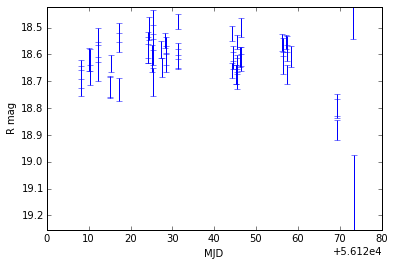

In [10]:
source_idx = 62
plt.errorbar(mjds, mags[source_idx,:],magerrs[source_idx,:],fmt='none')
plt.ylim(np.max(mags[source_idx,:])+0.05, np.min(mags[source_idx,:])-0.05)
plt.xlabel("MJD")
plt.ylabel("R mag")

print "scatter = %.3f" % (np.ma.std(mags[source_idx,:]))

(-0.2, 0.5)

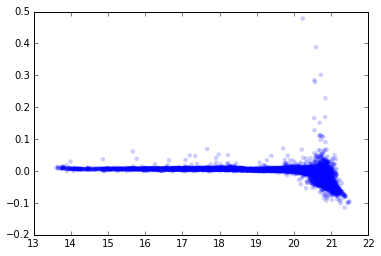

In [11]:
plt.scatter(np.ma.median(mags,axis=1), np.ma.std(mags,axis=1)**2. - np.ma.mean(magerrs**2.,axis=1), 
            edgecolor = "None", alpha = 0.2)
plt.ylim(-0.2,0.5)

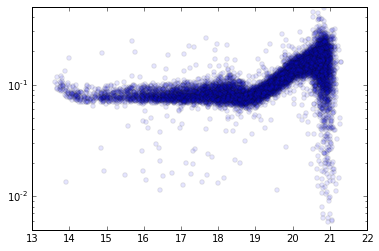

In [12]:
# examine a plot of the typical scatter as a function of magnitude

plt.scatter(np.ma.median(mags,axis=1), np.ma.std(mags,axis=1),alpha=0.1)
plt.ylim(0.005,0.5)
plt.yscale("log")

#cindarella's shoe!!

In [13]:
def relative_photometry(ref_mags, star_class, mags, magerrs):
    #make copies, as we're going to modify the masks
    all_mags = mags.copy()
    all_errs = magerrs.copy()
    
    # average over observations
#     medmags = np.ma.median(all_mags,axis=1)  # use the mag in the reference image
    refmags = np.ma.array(ref_mags[:,0])
#     stdmags = np.ma.std(all_mags,axis=1)     # use outlier resistant median absolute deviation
    madmags = 1.48*np.ma.median(np.abs(all_mags - np.ma.median(all_mags, axis = 1).reshape(len(ref_mags),1)), axis = 1)
    MSE = np.ma.mean(all_errs**2.,axis=1)

    # exclude bad stars: highly variable, saturated, or faint
    # use excess variance to find bad objects
    excess_variance = madmags**2. - MSE
    wbad = np.where((np.abs(excess_variance) > 0.1) | (refmags < 14.5) | (refmags > 17) | (star_class < 0.9))
    # mask them out
    refmags[wbad] = np.ma.masked
    
    # exclude stars that are not detected in a majority of epochs
    Nepochs = len(all_mags[0,:])
    nbad = np.where(np.ma.sum(all_mags > 1, axis = 1) <= Nepochs/2.)
    refmags[nbad] = np.ma.masked

    # for each observation, take the median of the difference between the median mag and the observed mag
    # annoying dimension swapping to get the 1D vector to blow up right
    relative_zp = np.ma.median(all_mags - refmags.reshape((len(all_mags),1)),axis=0)

    return relative_zp

In [14]:
# compute the relative photometry and subtract it. Don't fret about error propagation
rel_zp = relative_photometry(ref_mags, star_class, mags, magerrs)
mags -= np.ma.resize(rel_zp, mags.shape)

scatter = 0.052


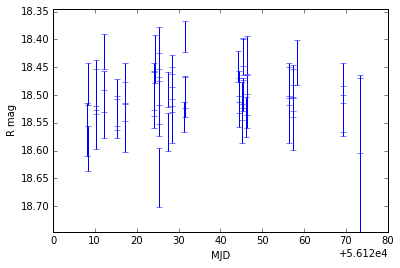

In [15]:
source_idx = 62
plt.errorbar(mjds, mags[source_idx,:],magerrs[source_idx,:],fmt='none')
plt.ylim(np.max(mags[source_idx,:])+0.05, np.min(mags[source_idx,:])-0.05)
plt.xlabel("MJD")
plt.ylabel("R mag")

print "scatter = %.3f" % (np.ma.std(mags[source_idx,:]))

(13, 22)

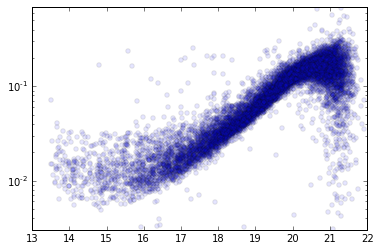

In [16]:
plt.scatter(ref_mags[:,0], np.ma.std(mags,axis=1),alpha=0.1)
plt.ylim(0.003,0.7)
plt.yscale("log")
plt.xlim(13,22)

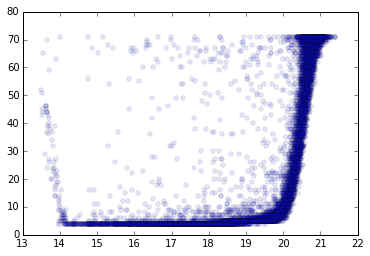

In [17]:
plt.scatter(np.ma.median(mags,axis=1), np.ma.sum(mags.mask,axis=1),alpha=0.1)

In [19]:
# save the output: ref_coords, mjds, mags, magerrs.

outfile = reference_catalog.split('/')[-1].replace('ctlg','shlv')
shelf = shelve.open('../data/'+outfile,flag='c',protocol=pickle.HIGHEST_PROTOCOL)
shelf['mjds'] = mjds
shelf['mags'] = mags
shelf['magerrs'] = magerrs
shelf['ref_coords'] = ref_coords
shelf.close()

In [20]:
# demonstrate getting the data back out
shelf = shelve.open('../data/'+outfile)
for key in shelf.keys():
    print key, shelf[key].shape
shelf.close()

mags (14042, 72)
magerrs (14042, 72)
mjds (72,)
ref_coords (14042,)


In [21]:
def source_lightcurve(rel_phot_shlv, ra, dec, matchr = 1.0):
    """Crossmatch ra and dec to a PTF shelve file, to return light curve of a given star"""
    shelf = shelve.open(rel_phot_shlv)
    ref_coords = coords.SkyCoord(shelf["ref_coords"].ra, shelf["ref_coords"].dec,frame='icrs',unit='deg')    
    
    source_coords = coords.SkyCoord(ra, dec,frame='icrs',unit='deg')
    idx, sep, dist = coords.match_coordinates_sky(source_coords, ref_coords)        
    
    wmatch = (sep <= matchr*u.arcsec)
    
    if sum(wmatch) == 1:
        mjds = shelf["mjds"]
        mags = shelf["mags"][idx]
        magerrs = shelf["magerrs"][idx]
        
        return mjds, mags, magerrs

    else:
        return "There are no matches to the provided coordinates within %.1f arcsec" % (matchr)


In [22]:
ra, dec = 312.503802, -0.706603
source_mjds, source_mags, source_magerrs = source_lightcurve('../data/'+outfile, ra, dec)

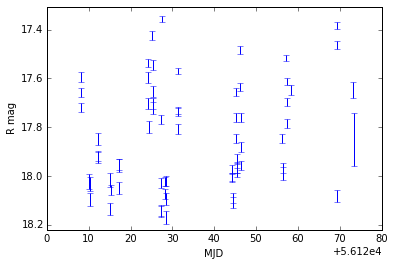

In [23]:
plt.errorbar(source_mjds, source_mags, source_magerrs, fmt = "None")
plt.ylim(np.max(source_mags)+0.05, np.min(source_mags)-0.05)
plt.xlabel("MJD")
plt.ylabel("R mag")